In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import xgboost as xgb
import seaborn as sns

In [216]:
data = pd.read_csv(r'C:\Users\kingd\OneDrive\سطح المكتب\Projects\ai workshop\SA_Aqar.csv')

In [217]:
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

numerical_columns = ['price', 'size', 'bedrooms', 'bathrooms', 'livingrooms']
data_cleaned = remove_outliers(data, numerical_columns)
data_cleaned = data_cleaned[data_cleaned['price'] > 0]

In [218]:
features = ['size', 'bedrooms', 'bathrooms', 'livingrooms', 'driver_room', 'kitchen']
categorical_features = ['city', 'front', 'property_age']
target = 'price'

X = data_cleaned[features + categorical_features].copy()
y = np.log1p(data_cleaned[target])

In [219]:
X['price_per_sqm'] = data_cleaned['price'] / data_cleaned['size']
X['total_rooms'] = data_cleaned['bedrooms'] + data_cleaned['bathrooms'] + data_cleaned['livingrooms']
X['room_density'] = X['total_rooms'] / data_cleaned['size']

In [220]:
le = LabelEncoder()
for col in categorical_features:
    X[col] = le.fit_transform(X[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [221]:
models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.005,
        max_depth=4,
        min_child_weight=2,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        objective='reg:squarederror'
    )
}

In [222]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = np.mean(np.abs(y_test - y_pred))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f'\n{name}:')
    print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
    print(f'Mean Absolute Error: {mae:,.2f}')
    print(f'Root Mean Squared Error: {rmse:,.2f}')
    print(f'Mean Absolute Percentage Error: {mape:.2f}%')


Linear Regression:
R² Score: 0.7967
Mean Absolute Error: 0.12
Root Mean Squared Error: 0.22
Mean Absolute Percentage Error: 1.11%

Gradient Boosting:
R² Score: 0.9925
Mean Absolute Error: 0.02
Root Mean Squared Error: 0.04
Mean Absolute Percentage Error: 0.20%

XGBoost:
R² Score: 0.9514
Mean Absolute Error: 0.06
Root Mean Squared Error: 0.11
Mean Absolute Percentage Error: 0.55%


In [223]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = models['XGBoost']
scores = cross_val_score(xgb_model, X_scaled, y, cv=kf, scoring='r2')
print("\nCross-validation R² scores:", scores)
print(f"Average R² score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


Cross-validation R² scores: [0.95185442 0.95902358 0.95132861 0.95259792 0.95808394]
Average R² score: 0.9546 (+/- 0.0066)


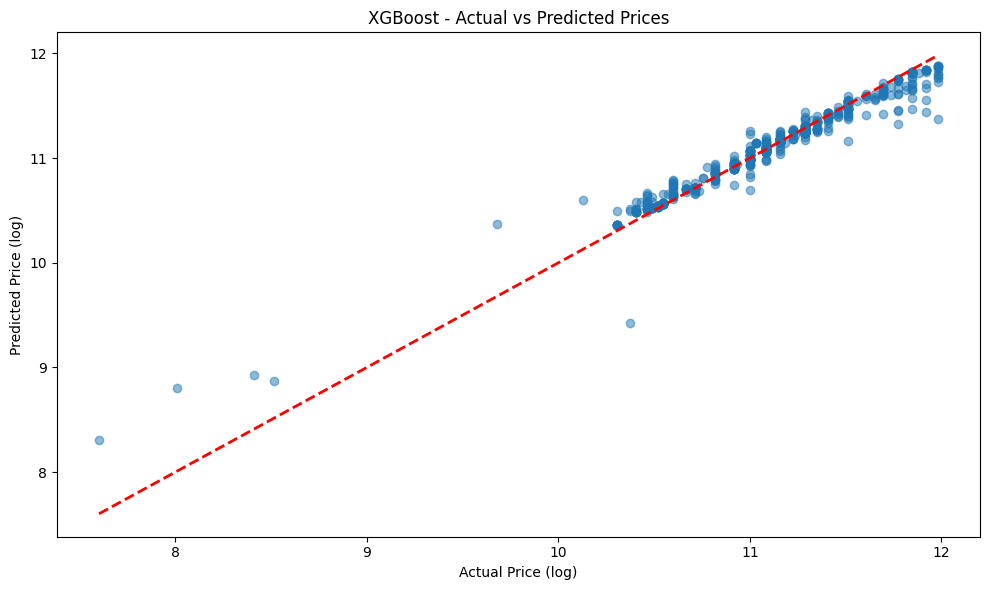

In [224]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, models['XGBoost'].predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (log)')
plt.ylabel('Predicted Price (log)')
plt.title('XGBoost - Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

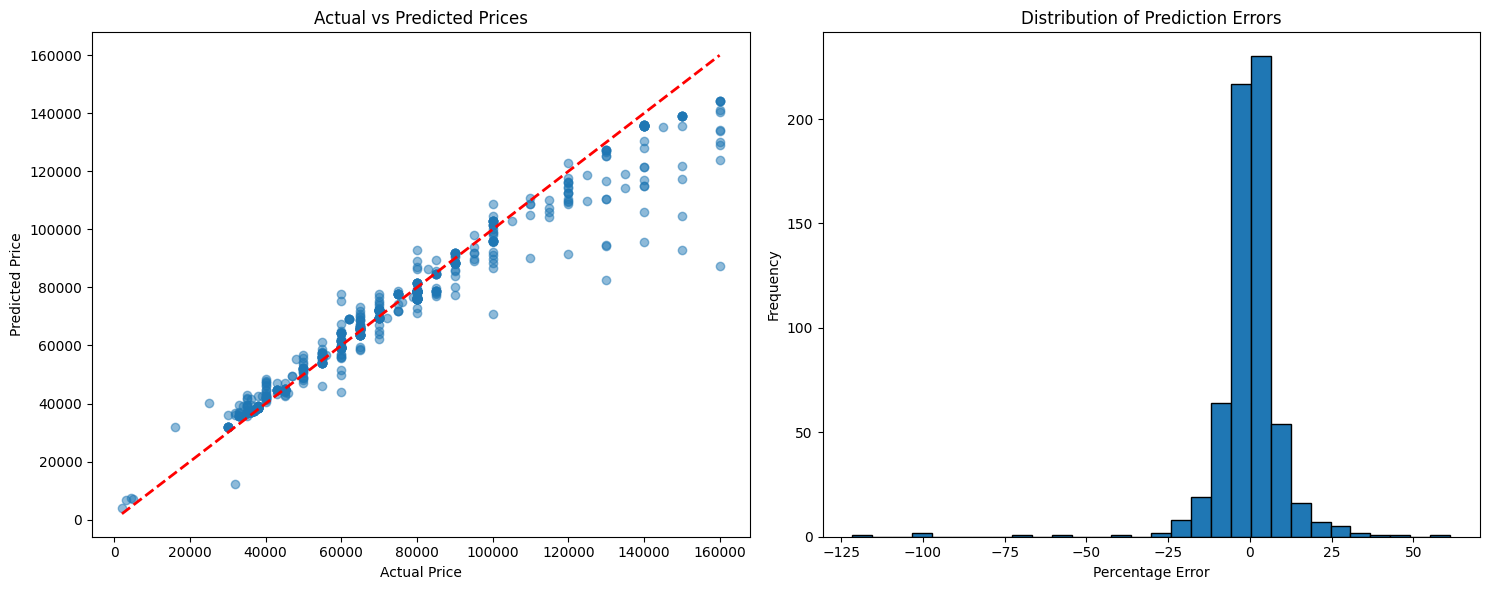


Average Error: 6.06%
90% of predictions are within 12.18% of actual value


In [230]:
# Convert predictions and actual values back from log scale
y_pred = models['XGBoost'].predict(X_test)
y_pred_actual = np.expm1(y_pred)
y_test_actual = np.expm1(y_test)

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Actual vs Predicted Plot
ax1.scatter(y_test_actual, y_pred_actual, alpha=0.5)
ax1.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', lw=2)
ax1.set_xlabel('Actual Price')
ax1.set_ylabel('Predicted Price')
ax1.set_title('Actual vs Predicted Prices')

# 2. Error Distribution
error_percentage = (y_test_actual - y_pred_actual) / y_test_actual * 100
ax2.hist(error_percentage, bins=30, edgecolor='black')
ax2.set_xlabel('Percentage Error')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Prediction Errors')

plt.tight_layout()
plt.show()

# Print simple summary
print(f"\nAverage Error: {np.mean(np.abs(error_percentage)):.2f}%")
print(f"90% of predictions are within {np.percentile(np.abs(error_percentage), 90):.2f}% of actual value")

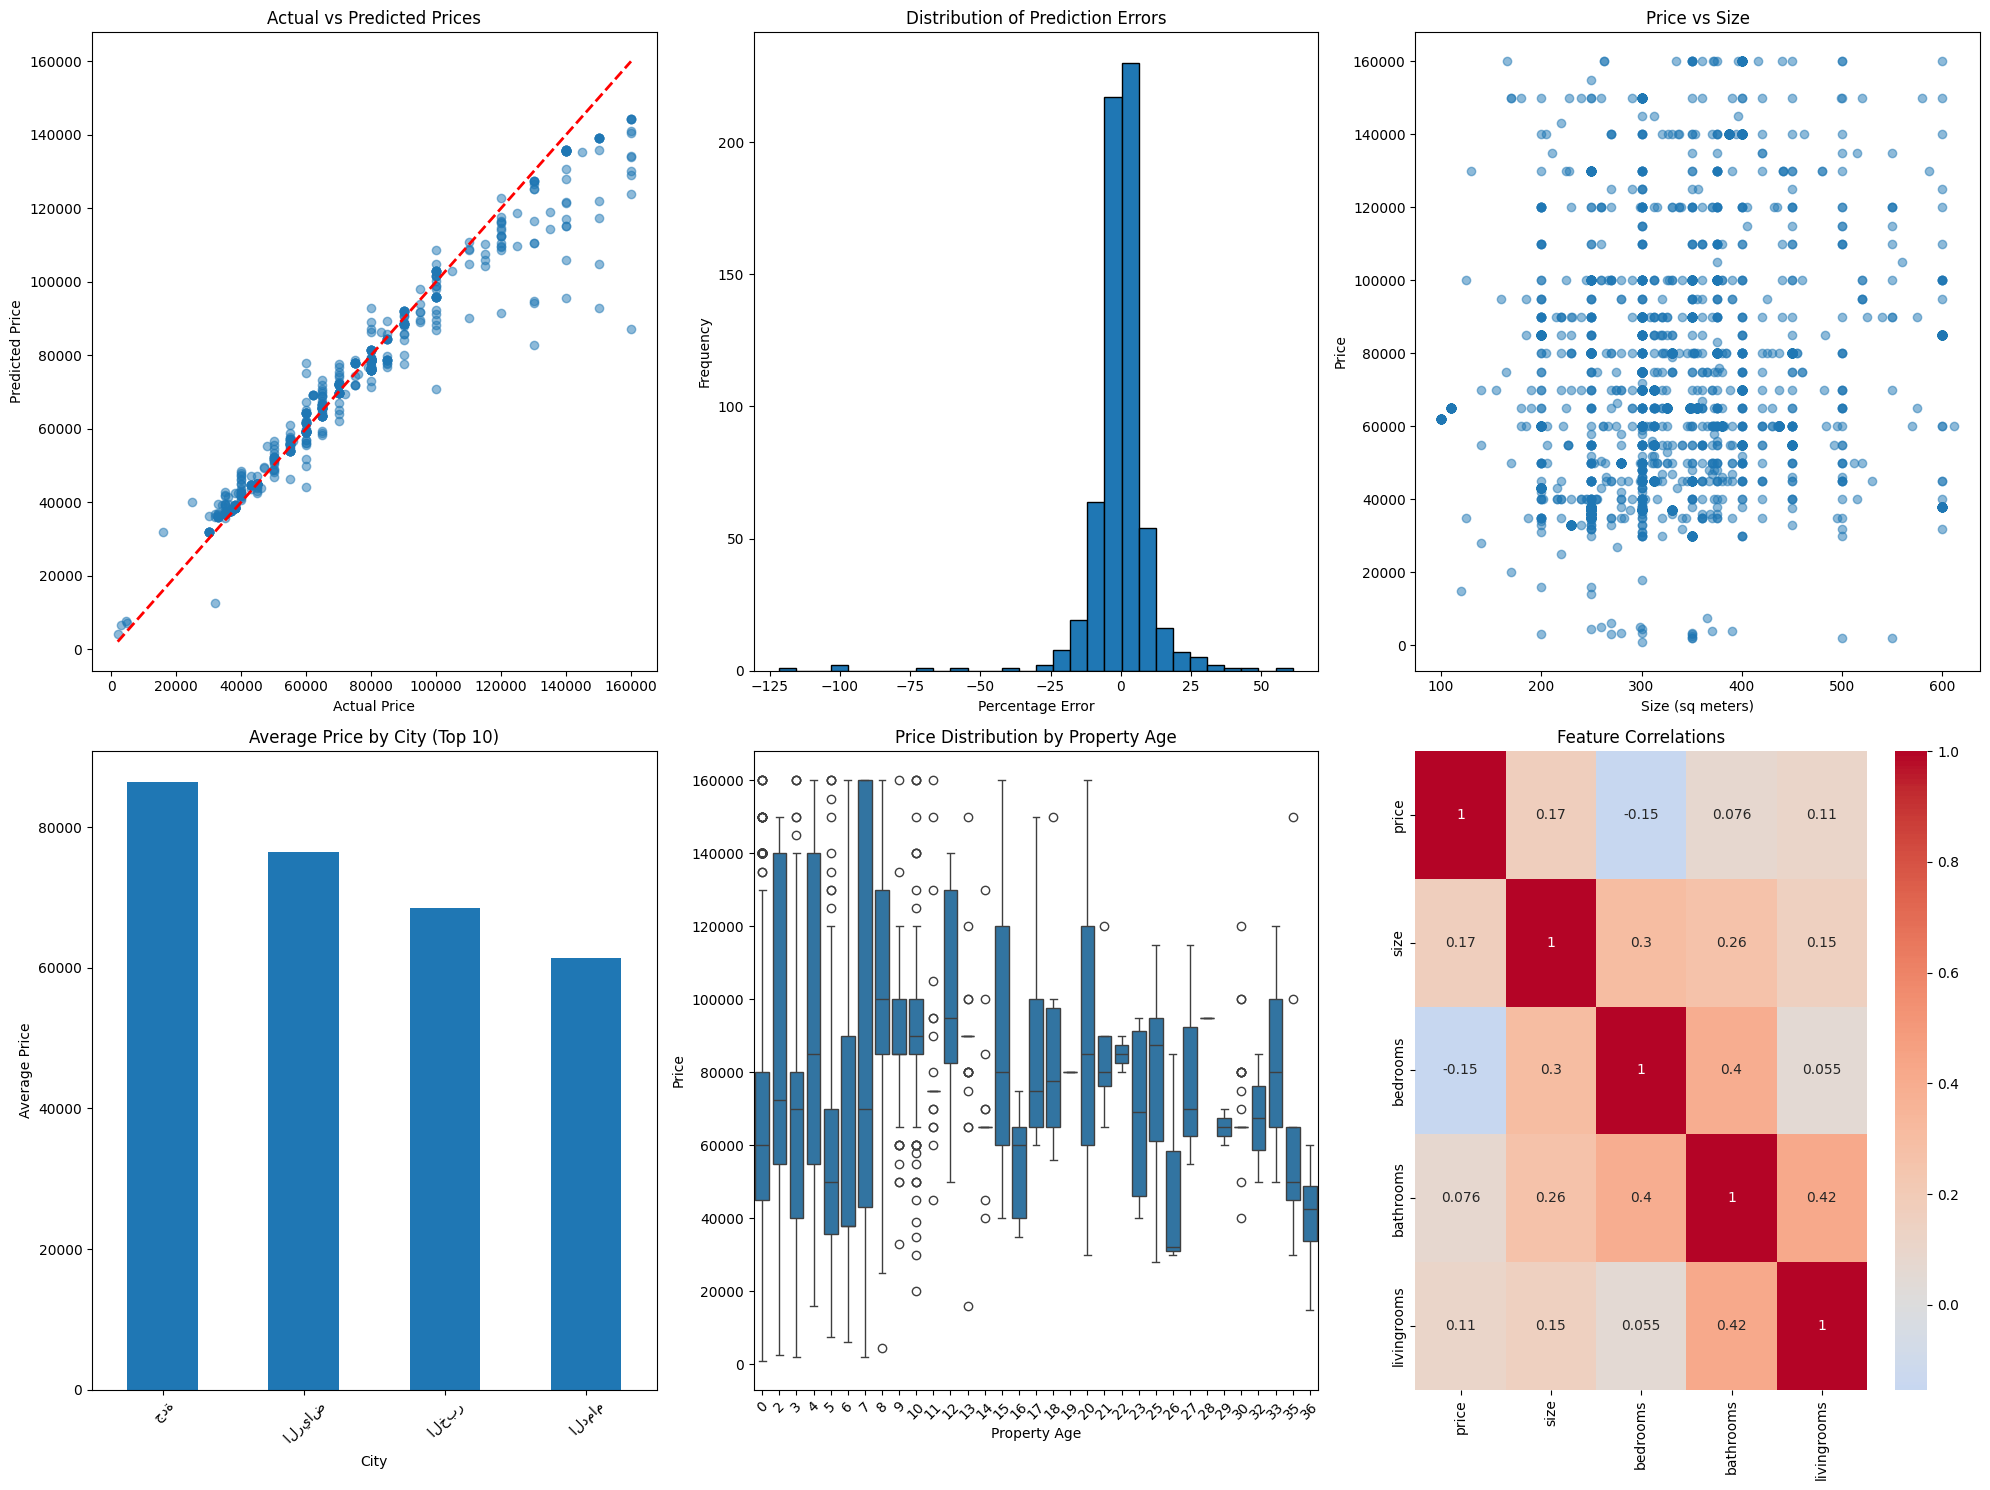


Key Statistics:
Average Price: 72,605.21
Median Price: 65,000.00
Average Size: 330.30 sq meters
Average Price per sq meter: 234.96

Model Performance:
Average Prediction Error: 6.06%
90% of predictions are within 12.18% of actual value


In [231]:
# Create a figure with 6 subplots
plt.figure(figsize=(20, 15))

# 1. Actual vs Predicted
plt.subplot(2, 3, 1)
plt.scatter(y_test_actual, y_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')

# 2. Error Distribution
plt.subplot(2, 3, 2)
error_percentage = (y_test_actual - y_pred_actual) / y_test_actual * 100
plt.hist(error_percentage, bins=30, edgecolor='black')
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')

# 3. Price vs Size Scatter
plt.subplot(2, 3, 3)
plt.scatter(data_cleaned['size'], data_cleaned['price'], alpha=0.5)
plt.xlabel('Size (sq meters)')
plt.ylabel('Price')
plt.title('Price vs Size')

# 4. Average Price by City
plt.subplot(2, 3, 4)
city_prices = data_cleaned.groupby('city')['price'].mean().sort_values(ascending=False).head(10)
city_prices.plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Average Price')
plt.title('Average Price by City (Top 10)')

# 5. Price Distribution by Property Age
plt.subplot(2, 3, 5)
sns.boxplot(x='property_age', y='price', data=data_cleaned)
plt.xticks(rotation=45)
plt.xlabel('Property Age')
plt.ylabel('Price')
plt.title('Price Distribution by Property Age')

# 6. Correlation Heatmap
plt.subplot(2, 3, 6)
numeric_cols = ['price', 'size', 'bedrooms', 'bathrooms', 'livingrooms']
correlation = data_cleaned[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')

plt.tight_layout()
plt.show()

# Print additional insights
print("\nKey Statistics:")
print(f"Average Price: {data_cleaned['price'].mean():,.2f}")
print(f"Median Price: {data_cleaned['price'].median():,.2f}")
print(f"Average Size: {data_cleaned['size'].mean():,.2f} sq meters")
print(f"Average Price per sq meter: {(data_cleaned['price'] / data_cleaned['size']).mean():,.2f}")
print("\nModel Performance:")
print(f"Average Prediction Error: {np.mean(np.abs(error_percentage)):.2f}%")
print(f"90% of predictions are within {np.percentile(np.abs(error_percentage), 90):.2f}% of actual value")